In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPooling2D,Rescaling,Concatenate, BatchNormalization,MaxPool2D,GlobalAveragePooling2D,Dropout,Flatten
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import VGG16,ResNet50,EfficientNetB7
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from PIL import Image
from itertools import combinations
import warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings("ignore")


2025-07-28 09:04:18.365173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753693458.546397      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753693458.603916      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
mixed_precision.set_global_policy('float32')

In [29]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (32,32)
EPOCHS=60
BATCH_SIZE=32
ROOT_DIR = "/kaggle/input/gtsrb-german-traffic-sign/"
SEED= 42

In [6]:
print(ROOT_DIR+'Train')

/kaggle/input/gtsrb-german-traffic-sign/Train


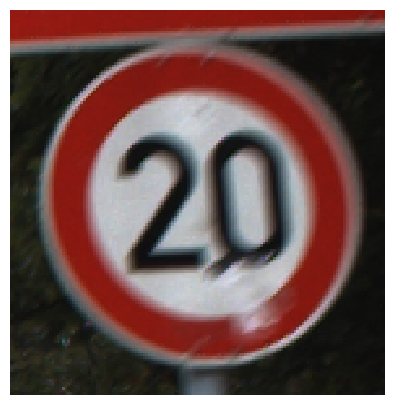

In [7]:
img_path="/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00029.png"
img = load_img(img_path)
plt.figure(figsize=(5,5))
plt.imshow(img, interpolation='nearest')
plt.axis('off')
plt.show()

In [8]:
df_train=pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Train.csv")
df_test=pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")

In [9]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [10]:
num_classes=len(df_train["ClassId"].unique())

In [11]:
num_classes

43

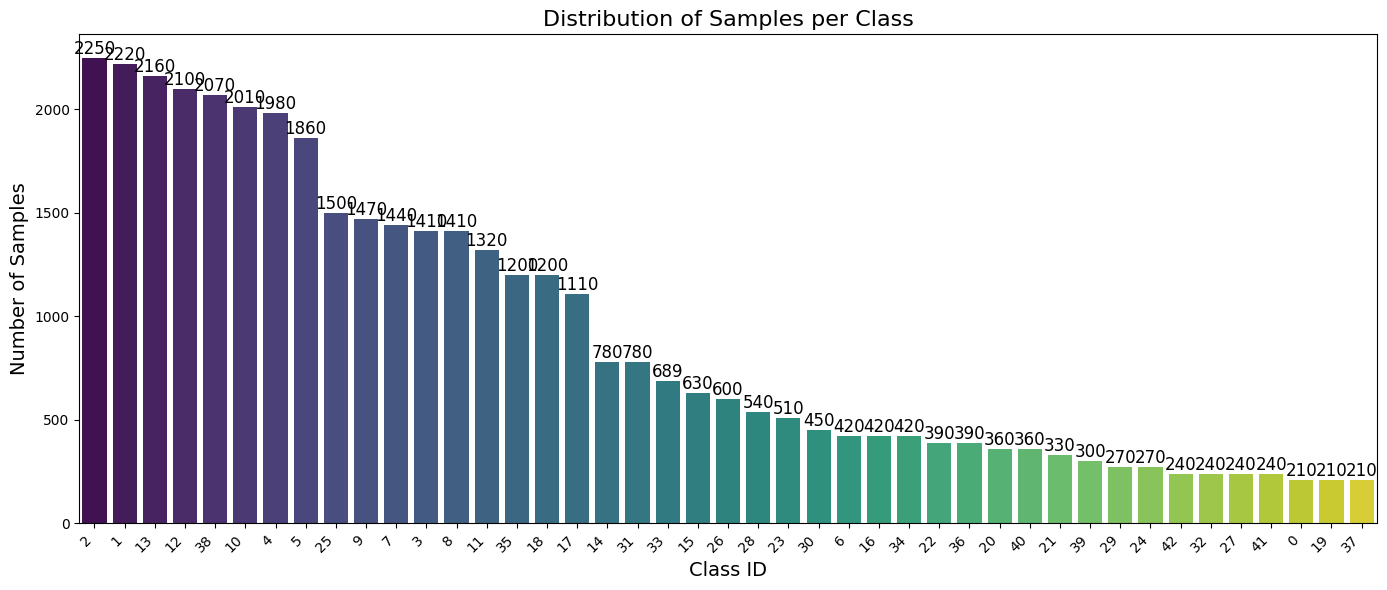

In [12]:
order = df_train['ClassId'].value_counts().index

plt.figure(figsize=(14, 6))
ax = sns.countplot(
    x='ClassId', 
    data=df_train, 
    order=order, 
    palette='viridis'
)

ax.set_xlabel("Class ID", fontsize=14)
ax.set_ylabel("Number of Samples", fontsize=14)
ax.set_title("Distribution of Samples per Class", fontsize=16)
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(
        f"{height}", 
        (p.get_x() + p.get_width() / 2, height), 
        ha='center', 
        va='bottom', 
        fontsize=12,
        color='black'
    )

plt.tight_layout()
plt.show()

In [13]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [14]:
df_train["Path"]=ROOT_DIR+"/"+df_train["Path"]
df_test["Path"]=ROOT_DIR+"/"+df_test["Path"]

In [15]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(
        factor=0.15, 
        fill_mode="reflect"
    ),
    tf.keras.layers.RandomTranslation(
        height_factor=0.1,  
        width_factor=0.1,     
        fill_mode="reflect"
    ),
    tf.keras.layers.RandomZoom(
        height_factor=0.05,   
        width_factor=0.05,
        fill_mode="reflect"
    ),
    tf.keras.layers.RandomContrast(factor=0.05)
])

rescale = tf.keras.layers.Rescaling(1./255)
def process(path,label):
    img=tf.io.read_file(path)
    img=tf.image.decode_image(img,channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img=rescale(img)
    return img,label
    


def make_dataset(df:pd.DataFrame,shuffle=False,augment=False):
    paths=tf.data.Dataset.from_tensor_slices(df["Path"])
    labels=tf.data.Dataset.from_tensor_slices(df["ClassId"])
    ds=tf.data.Dataset.zip((paths,labels))

    ds=ds.map(process,num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds=ds.shuffle(1000,SEED)
    if augment:
        ds=ds.map(lambda x,y:(augmentation(x,training=True),y),num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

I0000 00:00:1753693475.863660      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
df_train_split, df_val = train_test_split(df_train,test_size=0.2,stratify=df_train["ClassId"],random_state=SEED)
train_ds = make_dataset(df_train_split, shuffle=True,  augment=True)
val_ds   = make_dataset(df_val,         shuffle=False, augment=False)
test_ds  = make_dataset(df_test,        shuffle=False, augment=False)

In [17]:
samples = {}
import zipfile
ds = train_ds.unbatch() if hasattr(train_ds, 'unbatch') else train_ds


for image, label in ds:
    cls = int(label.numpy())
    if cls not in samples:
        samples[cls] = image
    if len(samples) == num_classes:
        break

with zipfile.ZipFile('one_sample_per_class.zip', 'w') as zf:
    for cls, img in samples.items():
        # Convert to uint8 and encode as PNG
        img_uint8 = tf.image.convert_image_dtype(img, tf.uint8)
        png_bytes = tf.io.encode_png(img_uint8).numpy()
        zf.writestr(f'{cls}.png', png_bytes)

print("Created one_sample_per_class.zip with 43 images.")

Created one_sample_per_class.zip with 43 images.


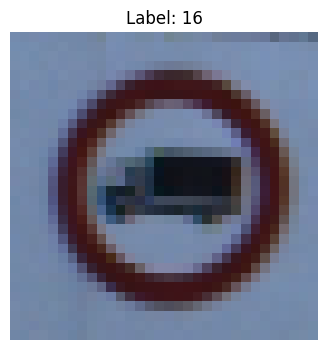

In [18]:
for image_batch, label_batch in test_ds.take(1):
    img = image_batch[0].numpy()
    lbl = label_batch[0].numpy()
    if img.dtype != 'uint8':
        img_disp = (img * 255).astype('uint8')
    else:
        img_disp = img

    plt.figure(figsize=(4,4))
    plt.imshow(img_disp)
    plt.title(f"Label: {lbl}")          
    plt.axis("off")
    plt.show()
    break

In [19]:
train_ds.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Images batch shape: (32, 32, 32, 3)
Labels batch shape: (32,)
Labels: [31  6 13 12 35  1  6 28 38  4 35  5 15 23 13  6  9  3 38 10 18 10 35  4
  2 29  5  5  9  8 38  5]


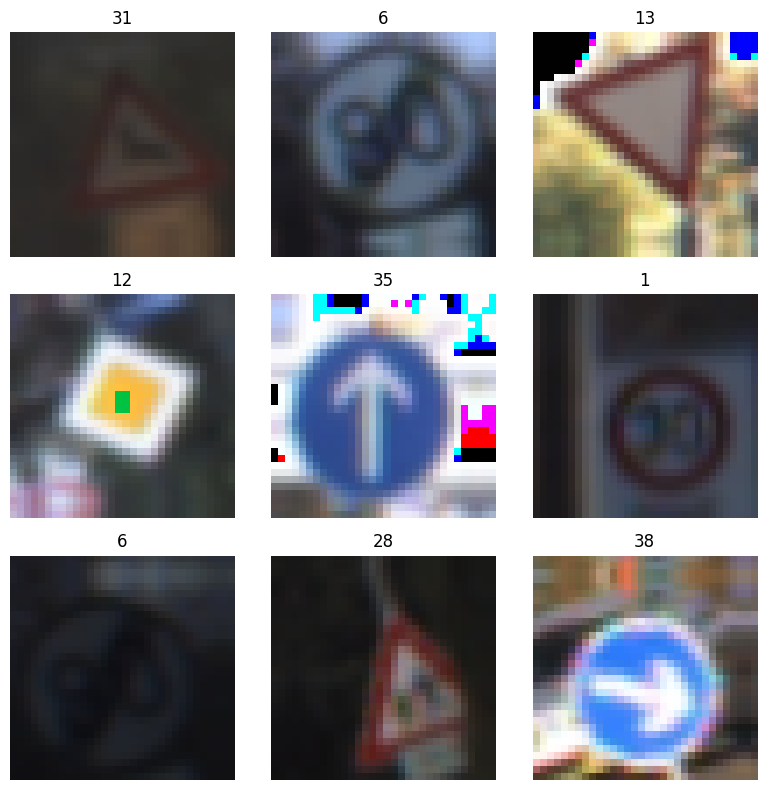

In [20]:
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Labels:", labels.numpy())
    num_to_show = min(9, images.shape[0])
    plt.figure(figsize=(8, 8))
    for i in range(num_to_show):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        if img.dtype != 'uint8':
            img = (img * 255).astype('uint8')
        plt.imshow(img)
        plt.title(str(labels[i].numpy()) )
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [21]:
def plot(history,filename="training_metrics.png"):
    accuracy      = history.history['accuracy']
    val_accuracy  = history.history['val_accuracy']
    loss          = history.history['loss']
    val_loss      = history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)
    
    plt.figure(figsize=(18, 5))
    
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, accuracy,      label='Train Acc')
    plt.plot(epochs, val_accuracy,  label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, loss,      label='Train Loss')
    plt.plot(epochs, val_loss,  label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def train(model,epochs):
    early_stop = EarlyStopping(monitor="val_accuracy",mode="max",patience=15,restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=15,min_lr=1e-6,verbose=2)
    history = model.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks= [early_stop, reduce_lr],verbose = 1)
    return history

In [30]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(*IMG_SIZE,3)))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(num_classes, activation='softmax'))

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,903,595 (7.26 MB)

 Trainable params: 1,903,595 (7.26 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

In [33]:
with tf.device('/GPU:0'):
    history=train(model,EPOCHS)

Epoch 1/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.2358 - loss: 2.7239 - val_accuracy: 0.8317 - val_loss: 0.5807 - learning_rate: 0.0010
Epoch 2/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7474 - loss: 0.7983 - val_accuracy: 0.9221 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 3/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.8790 - loss: 0.3816 - val_accuracy: 0.9717 - val_loss: 0.0889 - learning_rate: 0.0010
Epoch 4/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9241 - loss: 0.2506 - val_accuracy: 0.9760 - val_loss: 0.0829 - learning_rate: 0.0010
Epoch 5/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9374 - loss: 0.2020 - val_accuracy: 0.9842 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 6/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9488 - loss: 0.1749 - val_accuracy: 0.9844 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 7/60
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9534 - l

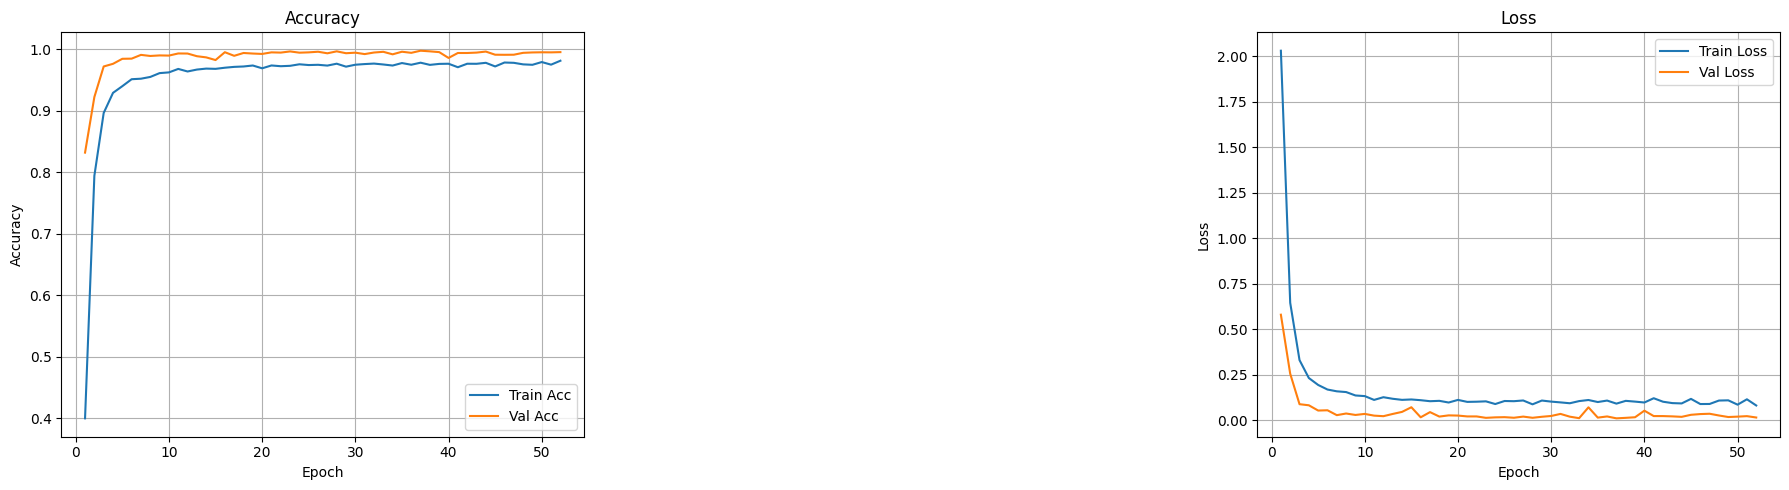

In [34]:
plot(history)

In [35]:
model.evaluate(test_ds)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9705 - loss: 0.2175


[0.2535446882247925, 0.9693586826324463]

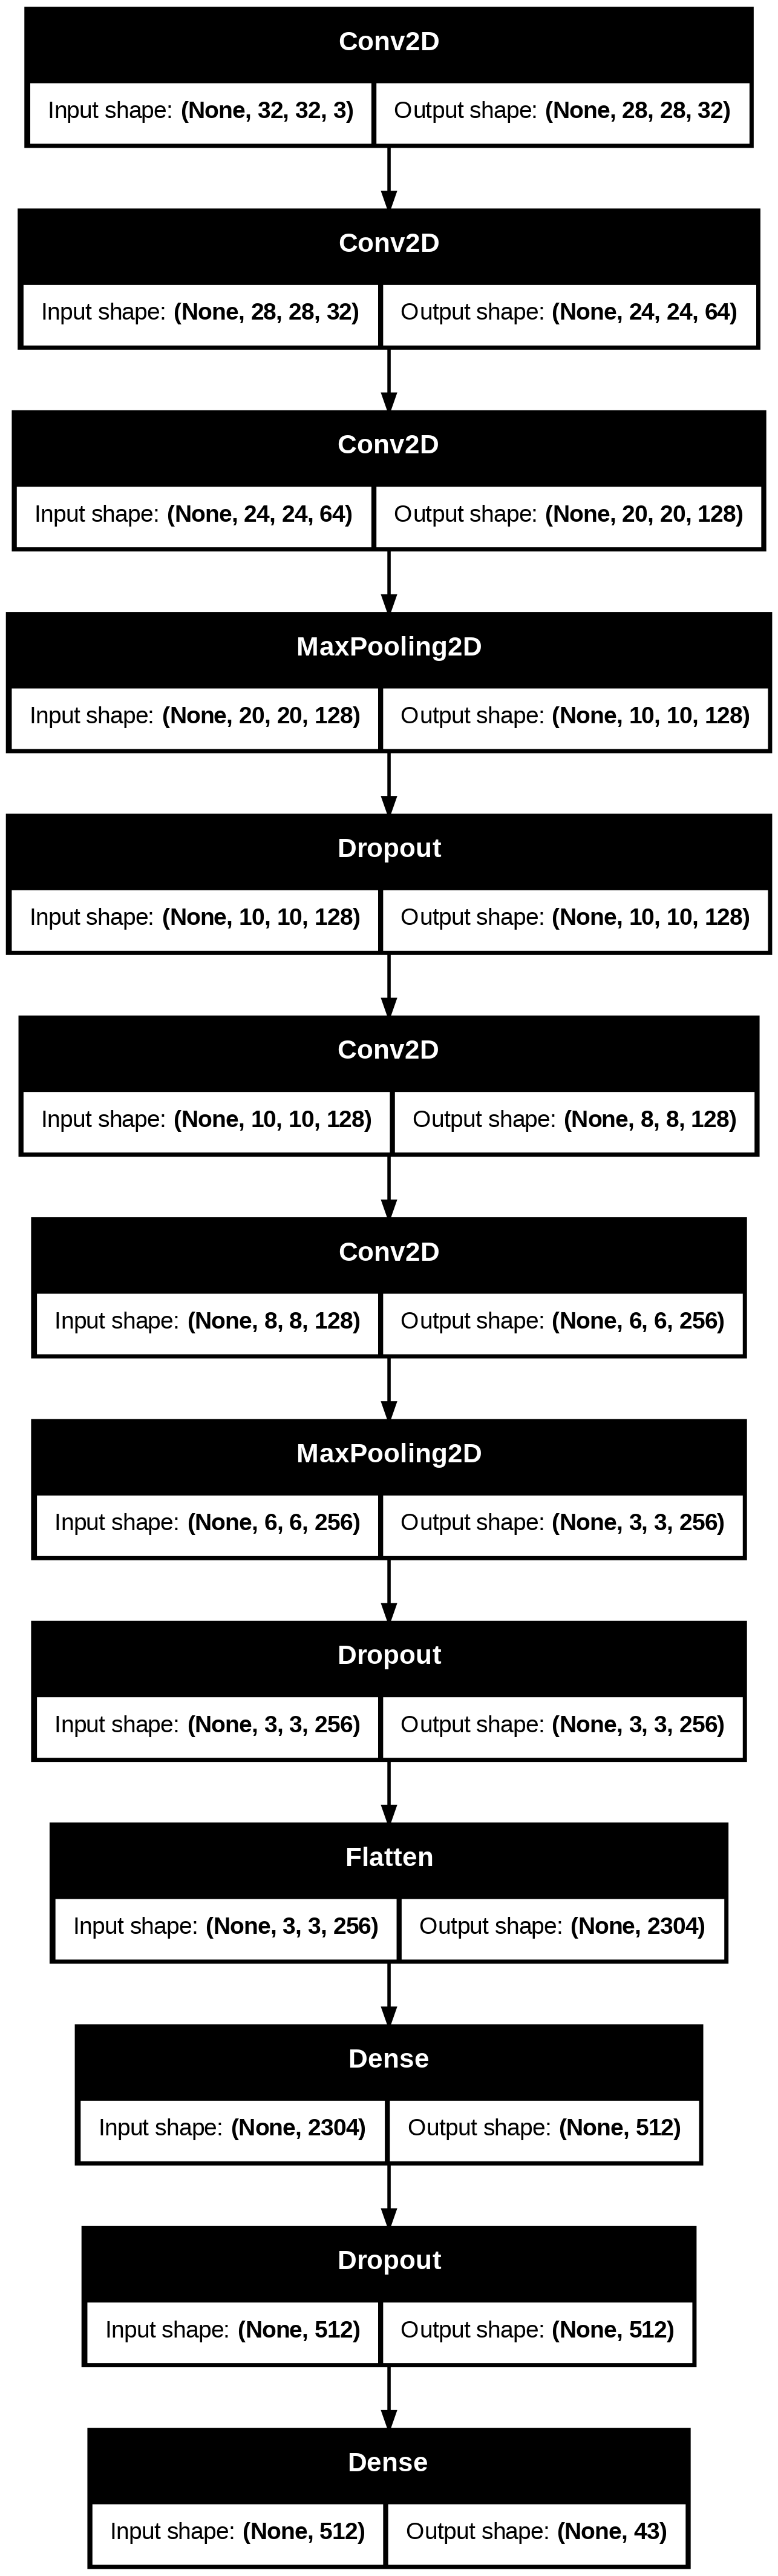

In [36]:
plot_model(model, to_file="architecture.png", show_shapes=True, expand_nested=True)

In [37]:
model.save("model.h5")

In [38]:
model=load_model("/kaggle/working/model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
True label: 3	Prediction: 3


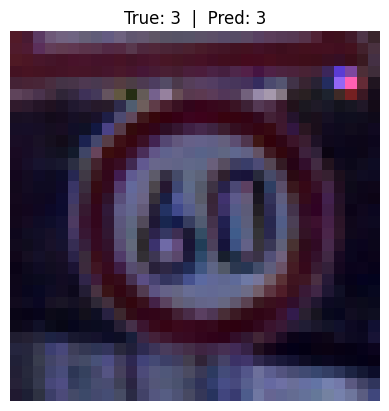

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
True label: 3	Prediction: 3


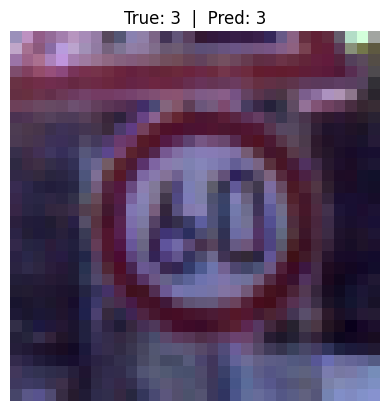

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True label: 38	Prediction: 38


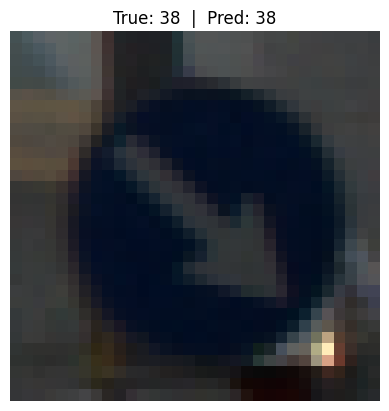

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
True label: 14	Prediction: 14


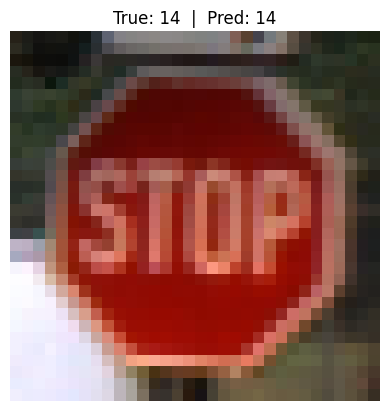

In [39]:
ds = test_ds.unbatch()
data = list(ds)
samples = random.sample(data, 4)

for img, label in samples:
    logits = model.predict(tf.expand_dims(img, 0))
    pred = int(tf.argmax(logits[0]))
    disp = array_to_img(img) 
    print(f"True label: {int(label)}\tPrediction: {pred}")
    plt.imshow(disp)
    plt.title(f"True: {int(label)}  |  Pred: {pred}")
    plt.axis('off')
    plt.show()